In [1]:
import json, glob, re
import matplotlib.pyplot as plt

outputDir = "output"
confL = []
for path in sorted(glob.glob("./.temp_files/*_dr.json")):
    confL.append( list(map( lambda d:float(d['confidence']), json.load(open(path,'r')) )) )
    print( len(confL[-1]) )

2518
4991
3000
809


In [2]:
with open(f"{outputDir}/output.txt","r") as f:
    txt = f.read()

In [3]:
print(f"mAP={ re.findall('mAP = (.*)', txt)[0] }")
print( re.findall(".{0,6} = .{1,2} AP",txt) )

mAP=86.70%
['93.92% = 0 AP', '91.69% = 1 AP', '92.26% = 2 AP', '68.94% = 3 AP']


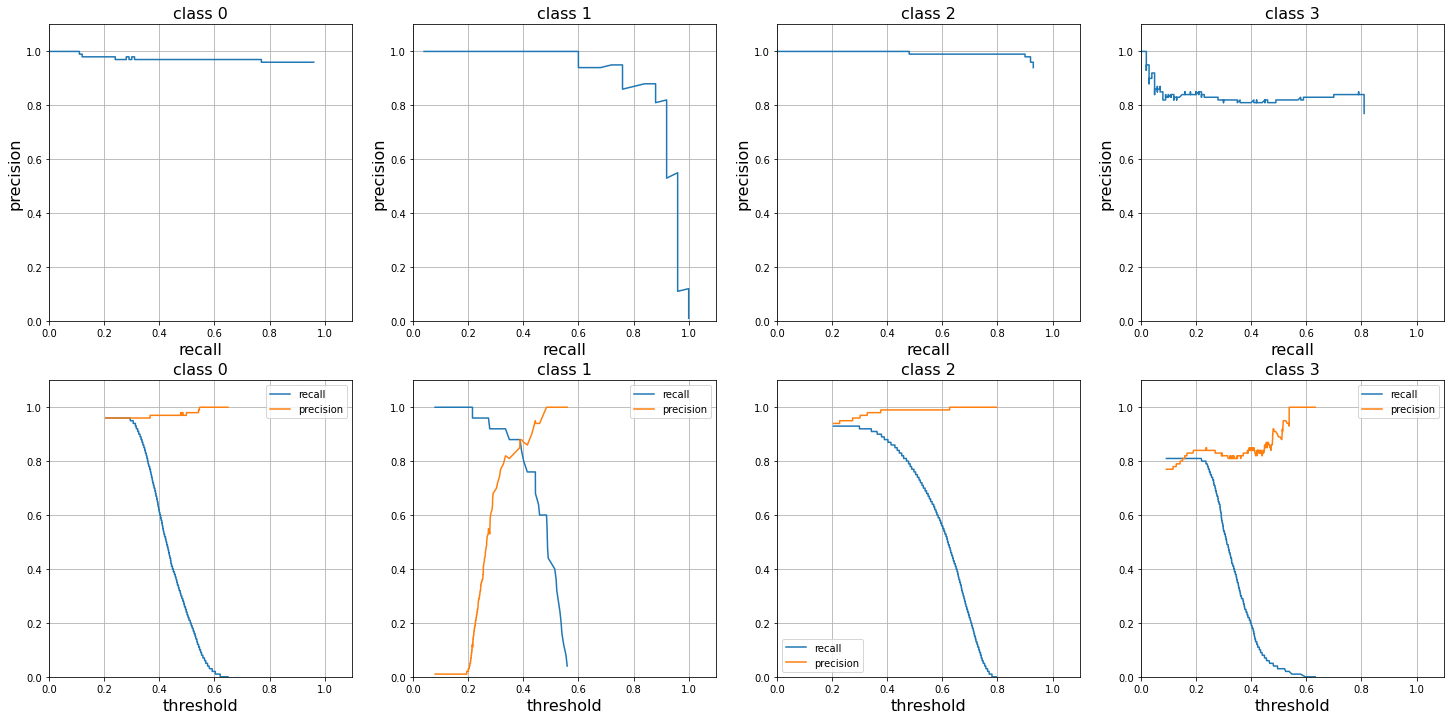

meanBestThreshold=0.311


In [4]:
meanBestThreshold = 0

plt.figure(figsize=(25,12))
for i,(recallLine,precisionLine) in enumerate( zip(re.findall("Recall :(.*)",txt),re.findall("Precision: (.*)",txt)) ):
    precisionL = json.loads( precisionLine.replace("\'","") )
    recallL    = json.loads( recallLine.replace("\'","") )
        
    plt.subplot(2,4,i+1)
    plt.plot(recallL, precisionL)
    plt.title(f"class {i}", fontsize=16)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.grid('on')
    
    plt.subplot(2,4,i+5)
    plt.plot(confL[i], recallL)
    plt.plot(confL[i], precisionL)
    plt.title(f"class {i}", fontsize=16)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(['recall','precision'])
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.grid('on')

    fscores = list(map(lambda i:2/(1/precisionL[i]+1/recallL[i]) if precisionL[i]*recallL[i]!=0 else 0, range(len(confL[i]))))
    bestF, bestThreshold = max( zip(fscores,confL[i]) )
    meanBestThreshold += bestThreshold/4
    
#plt.savefig(f"{outputDir}/PR_thres.jpg")
plt.show()
print(f"meanBestThreshold={round(meanBestThreshold,4)}")

# Detect by image

In [ ]:
import os, glob, re, cv2
import matplotlib.pyplot as plt

dtAntPathL = sorted(glob.glob("../exps/xavier_messy3k_DETReg_fine_tune_full_coco/txt/*.txt"))
dtImgPathL = sorted(glob.glob("../exps/xavier_messy3k_DETReg_fine_tune_full_coco/jpg/*.jpg"))
gtAntPathL = sorted(glob.glob("../data/labv2/testv2/yoloIntAnt/*.txt"))
gtImgPathL = sorted(glob.glob("../data/labv2/testv2/yoloIntImg/*.jpg"))
assert len(dtAntPathL)==len(dtImgPathL)==len(gtAntPathL)==len(gtImgPathL)

mAPL = []
for i,(dtAntPath, gtAntPath, gtImgPath) in enumerate(zip(dtAntPathL, gtAntPathL, gtImgPathL)):
    print(f"\r{i+1}/{len(dtAntPathL)}", end="")
    os.system("rm -r temp/*")
    os.system("mkdir temp/dtant temp/gtant temp/gtimg")
    os.system(f"cp {dtAntPath} temp/dtant && cp {gtAntPath} temp/gtant && cp {gtImgPath} temp/gtimg")
    out = os.popen(f"python main.py -na -np -q").read()
    mAPL.append( float(re.findall("mAP = (.*)\%\n", out)[0]) )

1511/3673

In [115]:
intervalCount = [0]*11 # AP: 0-10, 10-20, ..., 90-100, 100
for mAP in mAPL:
    intervalCount[round(mAP)//10]+=1
print(intervalCount)

resultL = sorted(zip(mAPL, dtImgPathL))

[127, 0, 0, 1, 0, 124, 9, 6, 2, 5, 3162]


In [ ]:
for i,(mAP,dtImgPath) in enumerate(resultL[:150]):
    print(i, mAP, dtImgPath.split('/')[-1])
    img = cv2.imread(dtImgPath)
    plt.figure(figsize=(20,10))
    plt.imshow(img[270:730,:,::-1])
    plt.axis('off')
    plt.show()